In [1]:
%pylab inline

from scipy.optimize import root_scalar
from scipy.integrate import trapezoid

Populating the interactive namespace from numpy and matplotlib


First, let's make a "qubit". This isn't a rigorous definition of a qubit, instead, we only define it with everything we need for this experiment. To this end, I have encoded the qubit's rotation around the y-axis as an intrinsic property of the qubit. This means that the qubit is being rotated around the $y$-axis on a time scale, which gives the qubit an internal "probability" of being measured in the $\lvert 1 \rangle$ state, depending on what time (after the rotation begins) you measure the qubit.

In [2]:
class Qubit:
    def __init__(self, seed, alpha, beta, phi0, c):
        self.alpha = alpha
        self.beta = beta
        self.phi0 = phi0
        self.c = c
        
        self.prob = lambda t: alpha / 2 * (1 - np.cos(c * t + phi0)) + beta
        
        self.rng = np.random.default_rng(seed)
        
    def measure(self, t, n=1):
        # The n parameter allows us to run multiple measurements for the same time step
        # with one function call. This speeds up the computation a bit.
        v = self.rng.random(size=n)
        p = self.prob(t)
        
        # "less than" ensures the probability actually works as intended
        return np.where(v < p, 1, 0)

We are first going to assume these qubits are "ideal", that is $\alpha = 1$ and $\beta = \phi_0 = 0$. Additionally, we assume that we also know the approximate period of $P(t)$, and that is approximately 6. You could do the math on what this means, but in essence, we also assume that $c=1$. This can be verified by the fact that we hope to find pi by finding the two times that the $\lvert 1 \rangle$ probability $= 0.5$, which should occur at $t = \pi/2c$ and $t=3\pi/2c$.

In [3]:
q = {}

for i in range(5):
    seed = 6 * i + 7 * (i % 3)
    print(f"Adding qubit with seed {seed}")
    q[i] = Qubit(seed, 1, 0, 0, 1)

Adding qubit with seed 0
Adding qubit with seed 13
Adding qubit with seed 26
Adding qubit with seed 18
Adding qubit with seed 31


Now we run the measurement. The paper indicates that they made 8192 ($2^{13}$) measurements on each qubit at **each** time step, from 0 to 6.3 with a step of 0.1. Thankfully I included an $n$ parameter in my qubits, so we can do all 8192 measurements with a single call. So we loop over the time steps, and then over the qubits to do it on all qubits.

In [4]:
time_steps = np.arange(0, 6.3, 0.1)

f = {}
for i in range(len(q)):
    vals = []
    n_measure = 8192
    for t in time_steps:
        m = q[i].measure(t, n_measure)
        frac = np.sum(m) / len(m)
        vals.append(frac)

    f[i] = np.asarray(vals)

Now engage the algorithm. We are going to perform steps 1 through 3 in the next cell.

# 1. 
Estimate $\alpha$ and $\beta$ as $\hat{\alpha}$ and $\hat{\beta}$:

$$
\begin{align}
\hat{\beta} &= \min_t{f(t)}\\
\hat{\alpha} + \hat{\beta} &= \max_t{f(t)}
\end{align}
$$

# 2.
Renormalize the fractions using these values of $\hat{\alpha}$ and $\hat{\beta}$ so that the minimum is 0 and the maximum is 1.

$$
f_1(t) = \frac{f(t) - \hat{\beta}}{\hat{\alpha}},
$$

which if you're keeping track means that

$$
f_1(t) \approx \frac{1 - \cos{(ct + \phi_0)}}{2}
$$

if $\alpha$ is close to $\hat{\alpha}$, and $\beta$ is close to $\hat{\beta}$.
 
# 3. 
Interpolate $f_1(t)$ to values inbetween the discretized time steps, and defining this function as $\tilde{f_1}(t)$

In [5]:
f1 = {}
f1_interp = {}
alpha_hat = {}
beta_hat = {}
for i in range(len(q)):
    beta_hat[i] = np.min(f[i])
    alpha_hat[i] = np.max(f[i]) - beta_hat[i]

    f1[i] = (f[i] - beta_hat[i]) / alpha_hat[i]
    f1_interp[i] = lambda x: np.interp(x, time_steps, f1[i])

    print(alpha_hat[i], beta_hat[i])

0.99951171875 0.0
0.999755859375 0.0
0.9996337890625 0.0
0.9993896484375 0.0
0.9996337890625 0.0


# 4. 

Now we want to find where $\tilde{f_1}(t) \approx 0.5$, close to $t_1 = 1.5$ and $t_2 = 4.5$. Since these are *estimates* of $t_1$ and $t_2$, we should accurately call them $\hat{t_1}$, and $\hat{t_2}$ Here I define an $f_2$ interpolation that is simply $f_1 - 0.5$ for root finding purposes, since the root finder looks for 0s.

In [6]:
t1 = {}
t2 = {}

for i in range(len(q)):
    f2 = lambda x: np.interp(x, time_steps, f1[i]) - 0.5

    t1[i] = root_scalar(f2, x0=1.5, x1=2).root
    t2[i] = root_scalar(f2, x0=4.5, x1=5).root

    print(t1[i], t2[i])

1.572289156626506 4.690566037735849
1.568433734939759 4.718088737201366
1.5612271540469975 4.719395711500975
1.5612989323843418 4.6981277533039645
1.5848115299334813 4.726103896103896


# 5. 

This step is the most abstract. We improve our estimations of $\hat{\alpha}$ and $\hat{\beta}$ using $\hat{t_1}$ and $\hat{t_2}$. We use $\hat{t_1}$ and $\hat{t_2}$ to estimate the time at which $f$ achieves its maximum value, $\hat{t}_{maxval}$, and when $f$ achieves its minimum value $\hat{t}_{minval}$, so that

$$
\begin{align}
\hat{\beta} &= \text{mean} \{ f_1(t) | |t - \hat{t}_{minval}| < \delta \} \\
\hat{\alpha} + \hat{\beta} &= \text{mean} \{ f_1(t) | |t - \hat{t}_{maxval}| < \delta \}
\end{align}
$$

which essentially means that we take the average of all $f(t)$ measurements within $\delta$ of the estimated max and minimum values to estimate $\hat{\alpha}$ and $\hat{\beta}$. In the paper we take $\delta = 0.1$

# 6.

Step 6 repeats the math in step 2 using our new predictions of $\hat{\alpha}$ and $\hat{\beta}$. A reminder:

$$
f_1(t) = \frac{f(t) - \hat{\beta}}{\hat{\alpha}},
$$

In [7]:
delta = 0.1

for i in range(len(q)):
    t_maxval = (t1[i] + t2[i]) / 2
    t_minval = t_maxval + (t2[i] - t1[i])

    # Indices of time steps that satisfy this condition
    tmax = np.where(np.abs((time_steps - t_maxval)) < delta)[0]
    tmin = np.where(np.abs((time_steps - t_minval)) < delta)[0]

    beta_hat[i] = np.mean(f[i][tmin])
    alpha_hat[i] = np.mean(f[i][tmax]) - beta_hat[i]

    f1[i] = (f[i] - beta_hat[i]) / alpha_hat[i]
    f1_interp[i] = lambda x: np.interp(x, time_steps, f1[i])

    print(alpha_hat[i], beta_hat[i])

0.99749755859375 0.0018310546875
0.9979248046875 0.00146484375
0.99700927734375 0.00244140625
0.9970703125 0.0020751953125
0.9976806640625 0.00146484375


# 7. 

Using the new estimates of $\hat{\alpha}$ and $\hat{\beta}$ we can refine our estimates of $\hat{t_1}$ and $\hat{t_2}$. We will take all $f(t)$ measurements within $\sim0.5$ of the previous estimates, and then fit a linear function $\gamma t + k$ to these values (usually about 5-10 values, depending on where exactly $\hat{t_1}$ and $\hat{t_2}$ fall). Then we find when this linear fit crosses $0.5$. 

In [8]:
t1_hat = {}
t2_hat = {}
for i in range(len(q)):
    # Indices of time steps that fulfill the above condition.
    t1_idx = np.where(np.abs((time_steps - t1[i])) < 0.5)[0]
    coeff_1 = np.polyfit(time_steps[t1_idx], f1[i][t1_idx], 1)

    # Once again subtracting 0.5 to find where the function = 0.5 not 0.
    fit_1 = lambda x: coeff_1[0] * x + coeff_1[1] - 0.5
    t1_hat[i] = root_scalar(fit_1, x0=1.5, x1=2).root

    # Indices of time steps that fulfill the above condition.
    t2_idx = np.where(np.abs((time_steps - t2[i])) < 0.5)[0]
    coeff_2 = np.polyfit(time_steps[t2_idx], f1[i][t2_idx], 1)

    # Once again subtracting 0.5 to find where the function = 0.5 not 0.
    fit_2 = lambda x: coeff_2[0] * x + coeff_2[1] - 0.5
    t2_hat[i] = root_scalar(fit_2, x0=4.5, x1=5).root


    print(t1_hat[i], t2_hat[i])

1.5661799378416041 4.702583562632504
1.5695902048975519 4.7189337270833045
1.5747105749961468 4.716152899037388
1.570077686331821 4.715106304760737
1.5771804016986812 4.721042627680196


# 8.

Estimate the integral 

$$
I = \int_{t_1}^{t_2}{(f(t) - \frac{1}{2}) dt} \approx \frac{1}{c}
$$

to obtain an estimate of $c$. We use the trapezoid rule to estimate this integral from the discrete time step measurements.

# 9.

With an estimate of $c$ we can finally estimate $\pi$:


$$
\pi \approx \frac{\hat{t}_2 - \hat{t}_1}{I}
$$


In [9]:
pi_guess = {}
c = {}
for i in range(len(q)):
    f_hat = lambda x: np.interp(x, time_steps, f[i])

    # Adding the t1 and t2 to the measured timesteps for integration purposes.
    t_idx = np.where((time_steps >= t1_hat[i]) & (time_steps <= t2_hat[i]))[0]
    t_integ = time_steps[t_idx]
    t_integ = np.insert(t_integ, 0, t1_hat[i])
    t_integ = np.append(t_integ, t2_hat[i])

    # Doing the same for the probability measured values
    y_integ = f[i][t_idx]
    y_integ = np.insert(y_integ, 0, f_hat(t1_hat[i]))
    y_integ = np.append(y_integ, f_hat(t2_hat[i]))

    # Trapezoidal rule on the given points
    I = np.trapz(y_integ - 0.5, t_integ)
    
    c[i] = 1 / I

    # And the final guess!
    pi_guess[i] = (t2_hat[i] - t1_hat[i]) / I
    print(pi_guess[i])

3.146860302710061
3.150230379256289
3.144452995068471
3.1489040011845426
3.150058711795221


Let's average up all our guesses now to improve our overall guess (we hope).

In [10]:
pi_init = np.nanmean(list(pi_guess.values()))
pi_init, 100 * (np.pi - pi_init) / np.pi

(3.1481012780029167, -0.20717594961544175)

In [11]:
def prob_func(t, alpha, beta, phi0, c):
    return alpha / 2 * (1 - np.cos(c * t + phi0)) + beta


def plot_qubits(args):
    fig, ax = plt.subplots(5, figsize=(10, 35))

    q = args[0]
    f = args[1]
    alpha_hat = args[2]
    beta_hat = args[3]
    c = args[4]

    for i in range(len(c)):
        ax[i].set_title(f"Qubit {i + 1}")
        ax[i].set_ylim(-0.05, 1.05)
        ax[i].plot(time_steps, f[i], ".")

        # Plot the fitted probabilty function
        ax[i].plot(time_steps, prob_func(time_steps, alpha_hat[i], beta_hat[i], 0, c[i]))
        
        text_str = "\n".join(["Estimated values:",
                              f"alpha = {alpha_hat[i]:.3f}", f"beta = {beta_hat[i]:.3f}", 
                              f"c = {c[i]:.3f}"])
        ax[i].text(0, 0.82, text_str, fontsize=16)
        
        # Plot the true probability function
        ax[i].plot(time_steps, prob_func(time_steps, q[i].alpha, q[i].beta, 0, q[i].c))
        
        text_str = "\n".join(["True values:",
                              f"alpha = {q[i].alpha:.3f}", f"beta = {q[i].beta:.3f}", 
                              f"c = {q[i].c:.3f}"])
        ax[i].text(5, 0.82, text_str, fontsize=16)
       

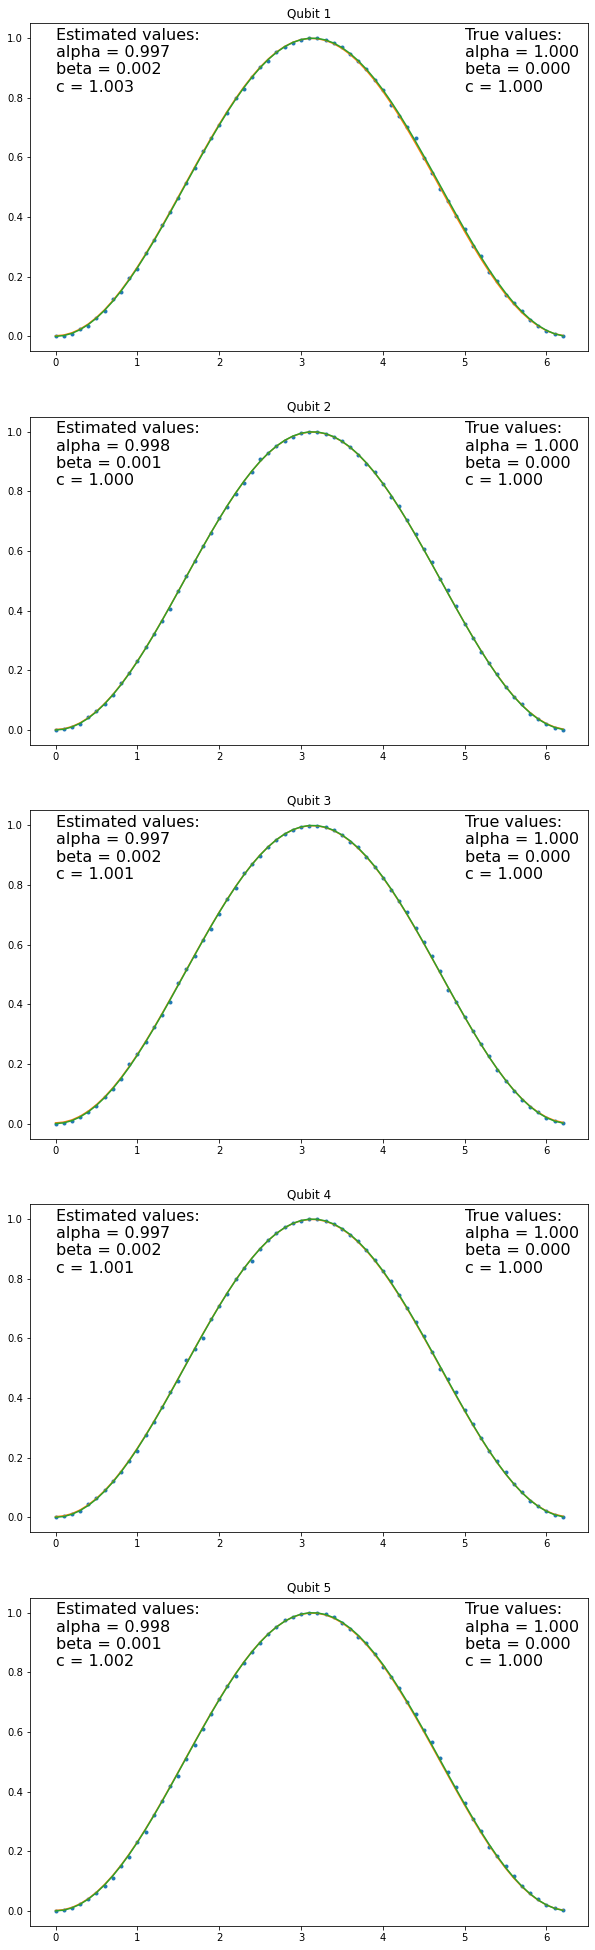

In [12]:
plot_qubits((q, f, alpha_hat, beta_hat, c))

That's not so bad, although granted this was an ideal case, and we used more qubits than in the paper. The paper uses 3 of the 5 experimental qubits, where here we ended up keeping all 5 of the qubits.

We might be tempted to see what would happen if we had, I don't know, 500 qubits. Let's see how this improves our guess. This next cell also abstracts out the above loop into its own function, so we can mess around with it later. 

In [13]:
def run_simulation(n_qubits, n_measure=8192, alpha_range=None, beta_range=None, phi_range=None, 
                   c_range=None, verbose=True, return_coeffs=False, 
                   time_steps=np.arange(0, 6.3, 0.1)):
    q = {}
    
    # Storing these for plotting purposes.
    if return_coeffs:
        fs = {}
        a = {}
        b = {}
        cs = {}
    
    pi_guess = {}
    
    # This rng is for varying alpha/beta
    rng = np.random.default_rng(91701)

    for i in range(n_qubits):
        seed = 6 * i + 7 * (i % 3)
        alpha = 1
        beta = 0
        c = 1
        phi_0 = 0
        
        if alpha_range is not None:
            if len(alpha_range) == 1: alpha = alpha_range[0]
            else:
                alpha = rng.random() * (alpha_range[-1] - alpha_range[0]) + alpha_range[0]
                if alpha < 0: alpha = 0
            
        if beta_range is not None:
            beta = rng.random() * (beta_range[-1] - beta_range[0]) + beta_range[0]
            if beta > 1 - alpha: beta = 1 - alpha # Normalization procedure
            if beta < 0: beta = 0
            
        if phi_range is not None:
            if len(phi_range) == 1: phi_0 = phi_range[0]
            phi_0 = rng.random() * (phi_range[-1] - phi_range[0]) + phi_range[0]
            
        if c_range is not None:
            if len(c_range) == 1: c = c_range[0]
            c = rng.random() * (c_range[-1] - c_range[0]) + c_range[0]

        
        if verbose: print(f"Adding qubit with seed {seed}, alpha {alpha}, beta {beta}, phi_0 {phi_0}, c {c}")
        q[i] = Qubit(seed, alpha, beta, phi_0, c)

        vals = []
        for t in time_steps:
            m = q[i].measure(t, n_measure)
            frac = np.sum(m) / len(m)
            vals.append(frac)

        f = np.asarray(vals)  

        beta_hat = np.min(f)
        alpha_hat = np.max(f) - beta_hat

        f1 = (f - beta_hat) / alpha_hat
        f1_interp = lambda x: np.interp(x, time_steps, f1)

        f2 = lambda x: np.interp(x, time_steps, f1) - 0.5

        t1 = root_scalar(f2, x0=1.5, x1=2).root
        t2 = root_scalar(f2, x0=4.5, x1=5).root

        t_maxval = (t1 + t2) / 2
        t_minval = t_maxval + (t2 - t1)
        
        # If we estimate t_minval is larger than the max time_step then use that instead.
        if t_minval > time_steps[-1] : t_minval = time_steps[-1]

        # Indices of time steps that satisfy this condition
        tmax = np.where(np.abs((time_steps - t_maxval)) < delta)[0]
        tmin = np.where(np.abs((time_steps - t_minval)) < delta)[0]

        beta_hat = np.mean(f[tmin])
        alpha_hat = np.mean(f[tmax]) - beta_hat

        f1 = (f - beta_hat) / alpha_hat
        f1_interp = lambda x: np.interp(x, time_steps, f1)

        # Indices of time steps that fulfill the above condition.
        t1_idx = np.where(np.abs((time_steps - t1)) < 0.5)[0]
        coeff_1 = np.polyfit(time_steps[t1_idx], f1[t1_idx], 1)

        # Once again subtracting 0.5 to find where the function = 0.5 not 0.
        fit_1 = lambda x: coeff_1[0] * x + coeff_1[1] - 0.5
        t1_hat = root_scalar(fit_1, x0=1.5, x1=2).root

        # Indices of time steps that fulfill the above condition.
        t2_idx = np.where(np.abs((time_steps - t2)) < 0.5)[0]
        coeff_2 = np.polyfit(time_steps[t2_idx], f1[t2_idx], 1)

        # Once again subtracting 0.5 to find where the function = 0.5 not 0.
        fit_2 = lambda x: coeff_2[0] * x + coeff_2[1] - 0.5
        t2_hat = root_scalar(fit_2, x0=1.5, x1=2).root

        f_hat = lambda x: np.interp(x, time_steps, f)

        # Adding the t1 and t2 to the measured timesteps for integration purposes.
        t_idx = np.where((time_steps >= t1) & (time_steps <= t2))[0]
        t_integ = time_steps[t_idx]
        t_integ = np.insert(t_integ, 0, t1_hat)
        t_integ = np.append(t_integ, t2_hat)

        # Doing the same for the probability measured values
        y_integ = f[t_idx]
        y_integ = np.insert(y_integ, 0, f_hat(t1_hat))
        y_integ = np.append(y_integ, f_hat(t2_hat))

        # Trapezoidal rule on the given points
        I = np.trapz(y_integ - 0.5, t_integ)
        
        if return_coeffs:
            fs[i] = f
            a[i] = alpha_hat
            b[i] = beta_hat
            cs[i] = 1 / I

        # And the final guess!
        pi_guess[i] = (t2_hat - t1_hat) / I
        
    mean_pi_guess = np.nanmean(list(pi_guess.values()))
    if return_coeffs:
        return mean_pi_guess, q, fs, a, b, cs
    return mean_pi_guess

run_simulation(500)

Adding qubit with seed 0, alpha 1, beta 0, phi_0 0, c 1
Adding qubit with seed 13, alpha 1, beta 0, phi_0 0, c 1
Adding qubit with seed 26, alpha 1, beta 0, phi_0 0, c 1
Adding qubit with seed 18, alpha 1, beta 0, phi_0 0, c 1
Adding qubit with seed 31, alpha 1, beta 0, phi_0 0, c 1
Adding qubit with seed 44, alpha 1, beta 0, phi_0 0, c 1
Adding qubit with seed 36, alpha 1, beta 0, phi_0 0, c 1
Adding qubit with seed 49, alpha 1, beta 0, phi_0 0, c 1
Adding qubit with seed 62, alpha 1, beta 0, phi_0 0, c 1
Adding qubit with seed 54, alpha 1, beta 0, phi_0 0, c 1
Adding qubit with seed 67, alpha 1, beta 0, phi_0 0, c 1
Adding qubit with seed 80, alpha 1, beta 0, phi_0 0, c 1
Adding qubit with seed 72, alpha 1, beta 0, phi_0 0, c 1
Adding qubit with seed 85, alpha 1, beta 0, phi_0 0, c 1
Adding qubit with seed 98, alpha 1, beta 0, phi_0 0, c 1
Adding qubit with seed 90, alpha 1, beta 0, phi_0 0, c 1
Adding qubit with seed 103, alpha 1, beta 0, phi_0 0, c 1
Adding qubit with seed 116, alp

3.136269074107633

Or even, what about, if we double or even quadruple the number of measurements we took at each time step.

In [14]:
pi_double = run_simulation(5, n_measure=8192*2)
pi_quad = run_simulation(5, n_measure=8192*4)

print(f"Ideal estimate: {pi_init}")
print(f"Double measurements: {pi_double}")
print(f"Quad measurements: {pi_quad}")

Adding qubit with seed 0, alpha 1, beta 0, phi_0 0, c 1
Adding qubit with seed 13, alpha 1, beta 0, phi_0 0, c 1
Adding qubit with seed 26, alpha 1, beta 0, phi_0 0, c 1
Adding qubit with seed 18, alpha 1, beta 0, phi_0 0, c 1
Adding qubit with seed 31, alpha 1, beta 0, phi_0 0, c 1
Adding qubit with seed 0, alpha 1, beta 0, phi_0 0, c 1
Adding qubit with seed 13, alpha 1, beta 0, phi_0 0, c 1
Adding qubit with seed 26, alpha 1, beta 0, phi_0 0, c 1
Adding qubit with seed 18, alpha 1, beta 0, phi_0 0, c 1
Adding qubit with seed 31, alpha 1, beta 0, phi_0 0, c 1
Ideal estimate: 3.1481012780029167
Double measurements: 3.136014829948831
Quad measurements: 3.1393592620784245


Another simulation that deals with ideal qubits, and how we might improve our measurement with only a small change, would be to increase the "granularity" of our time step measurements. In the paper we use a time step of 0.1, but what if we did 0.05? or even 0.01? Well let's see how this improves our results.

In [15]:
pi_half_ts = run_simulation(5, time_steps=np.arange(0, 6.3, 0.05))
pi_tenth_ts = run_simulation(5, time_steps=np.arange(0, 6.3, 0.01))

print(f"Ideal estimate: {pi_init}")
print(f"Double measurements: {pi_half_ts}")
print(f"Quad measurements: {pi_tenth_ts}")

Adding qubit with seed 0, alpha 1, beta 0, phi_0 0, c 1
Adding qubit with seed 13, alpha 1, beta 0, phi_0 0, c 1
Adding qubit with seed 26, alpha 1, beta 0, phi_0 0, c 1
Adding qubit with seed 18, alpha 1, beta 0, phi_0 0, c 1
Adding qubit with seed 31, alpha 1, beta 0, phi_0 0, c 1
Adding qubit with seed 0, alpha 1, beta 0, phi_0 0, c 1
Adding qubit with seed 13, alpha 1, beta 0, phi_0 0, c 1
Adding qubit with seed 26, alpha 1, beta 0, phi_0 0, c 1
Adding qubit with seed 18, alpha 1, beta 0, phi_0 0, c 1
Adding qubit with seed 31, alpha 1, beta 0, phi_0 0, c 1
Ideal estimate: 3.1481012780029167
Double measurements: 3.139937722848934
Quad measurements: 3.140709301098572


Let's break down the reality a bit and see how it affects our results. For this first test, let's mess with $\alpha$ a little bit. Let's just adjust it a bit, with a little noise so that $0.95 \leq \alpha \leq 1.05$

Adding qubit with seed 0, alpha 0.9654724727152254, beta 0, phi_0 0, c 1
Adding qubit with seed 13, alpha 0.9599310674169538, beta 0, phi_0 0, c 1
Adding qubit with seed 26, alpha 1.0299865503891108, beta 0, phi_0 0, c 1
Adding qubit with seed 18, alpha 1.0091645058236063, beta 0, phi_0 0, c 1
Adding qubit with seed 31, alpha 0.973039101635416, beta 0, phi_0 0, c 1
Ideal estimate: 3.1481012780029167
Changing alpha: 3.285562389996089, 3.191597275037265


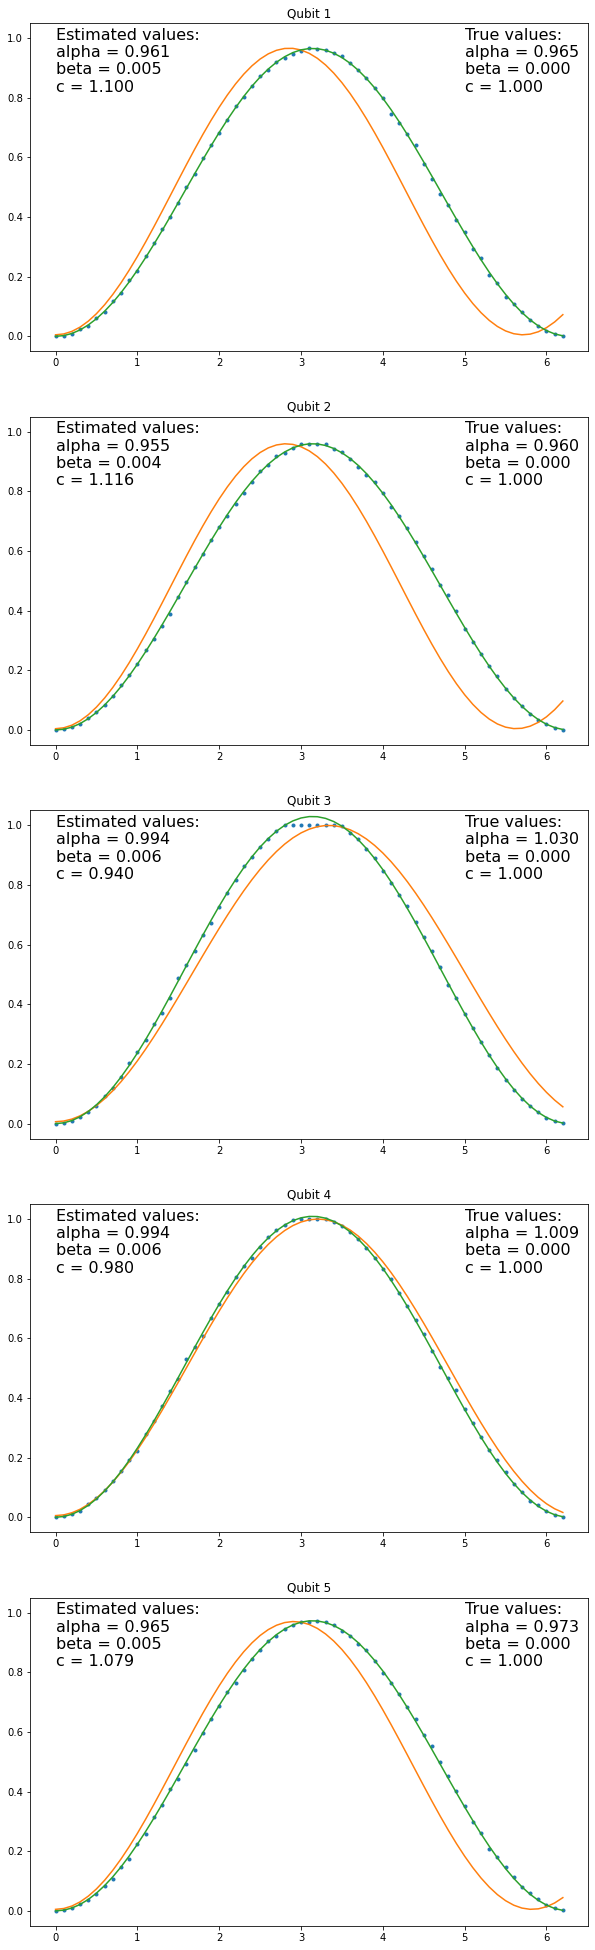

In [16]:
pi_alpha, *plot_coeffs = run_simulation(5, alpha_range=[0.95, 1.05], return_coeffs=True)
pi_alpha_500 = run_simulation(500, alpha_range=[0.95, 1.05], verbose=False)

print(f"Ideal estimate: {pi_init}")
print(f"Changing alpha: {pi_alpha}, {pi_alpha_500}")

plot_qubits(plot_coeffs)

We're not super robust to changes in alpha, thankfully as expected adding more qubits does bring us closer to the true result, although we're still over estimating (largely due to the fact that we didn't vary beta accordingly).

The next cell adjusts $\beta$ (which requires an $\alpha < 1$ to ensure the probability remains between 0 and 1.

Adding qubit with seed 0, alpha 0.99, beta 0.0015472472715225482, phi_0 0, c 1
Adding qubit with seed 13, alpha 0.99, beta 0.0009931067416953864, phi_0 0, c 1
Adding qubit with seed 26, alpha 0.99, beta 0.007998655038911078, phi_0 0, c 1
Adding qubit with seed 18, alpha 0.99, beta 0.005916450582360636, phi_0 0, c 1
Adding qubit with seed 31, alpha 0.99, beta 0.0023039101635416036, phi_0 0, c 1
Ideal estimate: 3.1481012780029167
Changing beta: 3.187439668159572, 3.1814767549455665


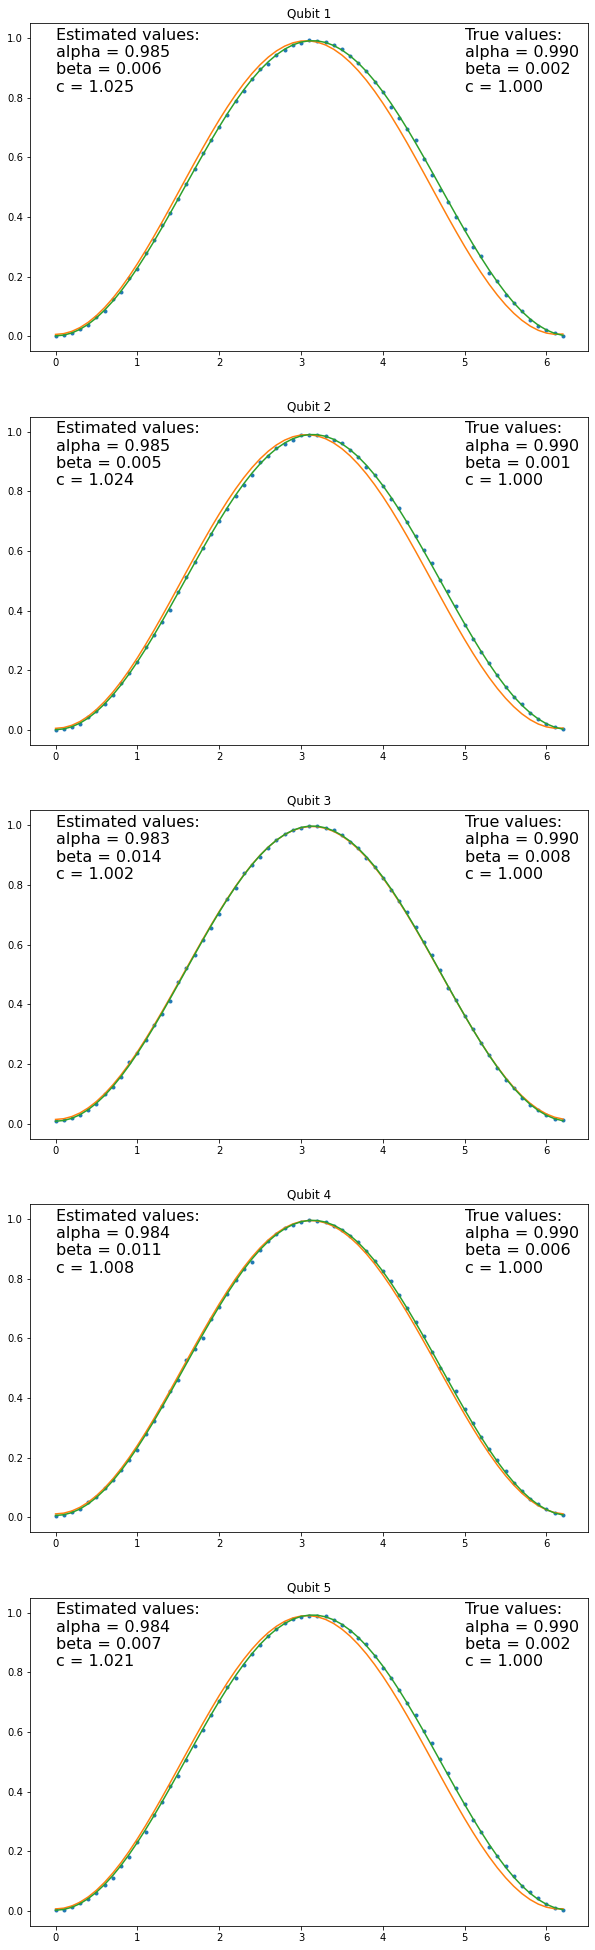

In [17]:
pi_beta, *plot_coeffs = run_simulation(5, alpha_range=[0.99], beta_range=[0, 0.01], return_coeffs=True)
pi_beta_500 = run_simulation(500, alpha_range=[0.95], beta_range=[0, 0.1], verbose=False)

print(f"Ideal estimate: {pi_init}")
print(f"Changing beta: {pi_beta}, {pi_beta_500}")

plot_qubits(plot_coeffs)

Fiddling with c actually improves our result more than any other variable, since by increasing $c$ we can ensure that the entire period of the probabilty function falls within the time step range (0-6.3). So even by just bumping it slightly to 1.1 we can ensure we cover an entire half period of the function. 

Adding qubit with seed 0, alpha 1, beta 0, phi_0 0, c 1.1
Adding qubit with seed 13, alpha 1, beta 0, phi_0 0, c 1.1
Adding qubit with seed 26, alpha 1, beta 0, phi_0 0, c 1.1
Adding qubit with seed 18, alpha 1, beta 0, phi_0 0, c 1.1
Adding qubit with seed 31, alpha 1, beta 0, phi_0 0, c 1.1
Ideal estimate: 3.1481012780029167
Changing c: 3.1463433849519995, 3.1426268056270947


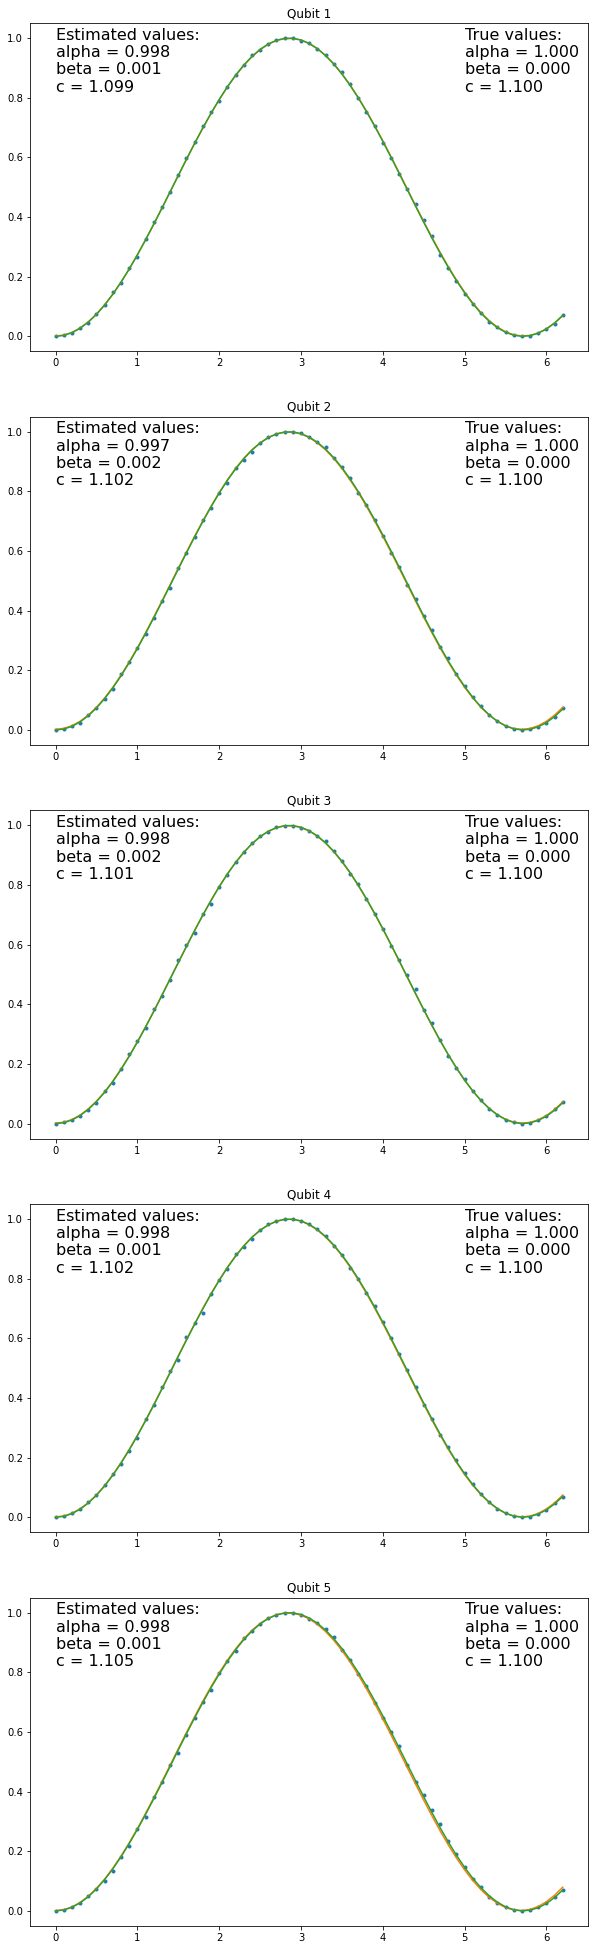

In [18]:
pi_c, *plot_coeffs = run_simulation(5, c_range=[1.1], return_coeffs=True)
pi_c_500 = run_simulation(500, c_range=[1.1], verbose=False)

print(f"Ideal estimate: {pi_init}")
print(f"Changing c: {pi_c}, {pi_c_500}")

plot_qubits(plot_coeffs)

The algorithm is somewhat rebosut to changes, and appreciably improves with more qubits (although maybe not as fast as we might have hoped). 

In the other notebook (extension.ipynb) we will investigate a way to speed up this improvement, by measuring both a half and whole period of the probability function so that we get two estimates of $\pi$ for each qubit.